## 训练一个图片分类器
步骤如下:
1. 从torchvision 加载CLFAR 10的训练数据和测试数据集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 使用训练数据集训练神经网络
5. 在测试集上测试神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

import torch.nn
import torch.nn.functional as F
import torch.optim as optim

### 1. 加载训练集和测试集

In [ ]:
# 将多个转化方法组合成一个
transform = transforms.Compose([
    transforms.ToTensor(),        # 将数据转化为张量
    # 给定均值和标准差 标准化一个张量图片
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
])

# 加载数据
trainset = datasets.CIFAR10('./datas/cifar-10-python.tar.gz', transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

testset = datasets.CIFAR10(
    './datas/cifar-10-python.tar.gz', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2
)

# 类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# 查看部分图片
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

(3, 36, 138)
(36, 138, 3)


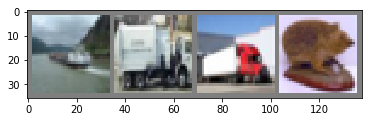

ship  truck  truck  cat


In [4]:
# 定义一个查看图片的函数
def imshow(img):
    img = img / 2 + 0.5    # 将标准化的图片还原
    npimg = img.numpy()    # 将张量转为numpy数组
    print(npimg.shape)
    print(np.transpose(npimg, (1, 2, 0)).shape)   # 数组位置调整
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(f'{"  ".join([classes[labels[i]] for i in range(4)])}')

### 2. 定义卷积神经网络(CNN)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 三个参数的含义分别为:输入通道数,输出通道数,卷积核数
        self.conv1 = nn.Conv2d(3, 6, 5)     # 对输入平面使用2维卷积
        self.pool = nn.MaxPool2d(2, 2)      # 池化
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 参数含义为:输入特征数,输出特征数
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 对输入的数据进行线性变换
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # 前向传播
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 将数据卷积后激活并池化
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16 * 5 * 5)              # 变换数据的形状,再次激活
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    
net = Net()

### 3. 构建损失函数

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()     # 交叉熵损失函数
# 优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 训练模型

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # data [inputs, labels]
        inputs, labels = data
        # 初始化梯度
        optimizer.zero_grad()
        
        # 前向 + 后向 + 优化器
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 查看状态
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss / 2000:.3F}%')
            running_loss = 0.0
print('Finished Training')

[1, 2000] loss: 2.223%
[1, 4000] loss: 1.888%
[1, 6000] loss: 1.681%
[1, 8000] loss: 1.558%
[1, 10000] loss: 1.504%
[1, 12000] loss: 1.459%
[2, 2000] loss: 1.372%
[2, 4000] loss: 1.335%
[2, 6000] loss: 1.328%
[2, 8000] loss: 1.292%
[2, 10000] loss: 1.270%
[2, 12000] loss: 1.240%
Finished Training


In [8]:
# 保存模型
path = './models/cifar_net.pth'
torch.save(net.state_dict(), path)

### 5. 测试模型

(3, 36, 138)
(36, 138, 3)


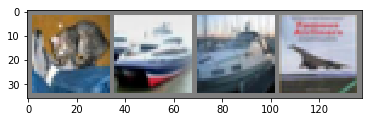

实际类别: ['cat', 'ship', 'ship', 'plane']


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(f'实际类别: {[classes[labels[i]] for i in range(4)]}')

In [13]:
# 加载模型
clf = Net()
clf.load_state_dict(torch.load(path))

outputs = clf(images)
a, predicted = torch.max(outputs.data, 1)
print(f'预测类别: {[classes[predicted[i]] for i in range(4)]}')

预测类别: ['cat', 'ship', 'ship', 'plane']


In [16]:
# 查看所有训练集的表现情况
corrent = 0 
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = clf(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        # .itme() 当张量中有且仅有一个元素时,可以使用此方法将其取出
        corrent += (predicted == labels).sum().item()
        
print(f'总数据量:{total}, 预测正确的数据量:{corrent}, 准确率:{(corrent / total) * 100}%')

总数据量:10000, 预测正确的数据量:5563, 准确率:55.63%


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [ ]:
13998186 - 2110